In [1]:
from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc._likelihood import chisq_2d, lnlike
from fit2d.models import PiecewiseModel

from astropy.io import fits
import copy
from datetime import datetime
import glob
import joblib
import numpy as np
import os

import emcee
from emcee import EnsembleSampler, moves

In [2]:
num_bins = 10
# min and max bounds for each bin
vmin, vmax = 0., 200.

# min and max inc, pos angle in RADIANS

inc_min, inc_max = np.radians(0), np.radians(90)
pos_angle_min, pos_angle_max = np.radians(0), np.radians(360)

name = "NGC2366"
distance = 3400. # [kpc]

home_directory = "/Users/stephencoffey/Downloads/little-things/data"
observed_2d_vel_field_fits_file = f"{home_directory}/NGC2366_1mom_cropped.fits"
# to use the dispersion as a source of errors, provide this file name
# observed_2d_dispersion_fits_file = f"{home_directory}/NGC2366_2mom.fits"
deg_per_pixel=4.17e-4

ring_param_file = f"{home_directory}/NGC2366_ring_parameters_rohit.txt"
v_systemic = 100 #changed to 100 to equal exactly what we used in mathematica

In [3]:
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape

mask_sigma=1.
random_seed = 1234

mcmc_nwalkers = 20
mcmc_niter = 1000
mcmc_ndim = 2  # Do not change this if fitting one ring at a time
mcmc_nthreads = 40
# Try increasing stretch scale factor a. version must be >=3 for this to be used.
mcmc_moves = moves.StretchMove(a = 2)
mcmc_version = float(emcee.__version__[0])

# Option to save every batch_size iterations in case of crash<br>
# Increase this; 2 is a very low value just for testing

batch_size = 100

# option to save outputs in a particular directory
save_dir = "/Users/stephencoffey/Downloads/little-things/notebooks/experiments/fake_gal/v_fixed_inc_1bin_all_fill_nan_vsys_croppedfield/tighterstart"

In [4]:
galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic
)

In [5]:
ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)
ring_param_bounds = [(vmin, vmax),(inc_min, inc_max)]

In [6]:
fit_structural_params = {"inc": 1}

In [7]:
bin_edges = np.linspace(ring_model.radii_kpc[0], ring_model.radii_kpc[-1], num_bins+1)
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2. for i in range(num_bins)]

In [8]:
v_err_const = 10. # [km/s] constant error per pixel
v_err_2d = None

In [9]:
import warnings
warnings.simplefilter('ignore')
from joblib import Parallel, delayed
from fit2d._velocity_field_generator import create_2d_velocity_field
import matplotlib.pyplot as plt

v_rot_fake = 40  # fill this in with something within the priors
inc_fake = np.radians(45)  # fill this in with something within the priors
pos_angle_fake = np.radians(45) # fill this in with something within the priors

# if inc and/or pos_angle are not being fit in the MCMC, they will be fixed to constant values inc_fake, pos_angle_fake

ring_model.update_structural_parameters(inc=inc_fake, pos_angle=pos_angle_fake)

In [10]:
# scans over inclinations values and pulls the chisq

chisq2d = []
incs = np.linspace(0.1, 0.99*np.pi/2, 100)
vrots = np.linspace(39.999, 40.001, 10)
bin_min, bin_max = bin_edges[0], bin_edges[-1]

fake_observed_2d_vel_field = create_2d_velocity_field(
        radii = [bin_min, bin_max],
        v_rot = [v_rot_fake, v_rot_fake],  # just fill in any velocity
        i = inc_fake,
        pa = pos_angle_fake,
        v_sys = galaxy.v_systemic,
        x_dim = galaxy.image_xdim,
        y_dim = galaxy.image_ydim,
        x_center = fits_xdim/2,
        y_center = fits_ydim/2,
        kpc_per_pixel = galaxy.kpc_per_pixel
    )

galaxy.observed_2d_vel_field = fake_observed_2d_vel_field
dimensions = fake_observed_2d_vel_field.shape

piecewise_model = PiecewiseModel(num_bins=1)
piecewise_model.set_bounds(array_bounds=ring_param_bounds)
piecewise_model.set_bin_edges(rmin=bin_edges[0], rmax=bin_edges[-1])
radii_to_interpolate = np.array([r for r in ring_model.radii_kpc if bin_edges[0]<=r<=bin_edges[-1]])
prior = LinearPrior(bounds=piecewise_model.bounds)
prior_transform = prior.transform_from_unit_cube
rotation_curve_func_kwargs = {
    "radii_to_interpolate": radii_to_interpolate}
lnlike_args = {
    "model": piecewise_model,
    "rotation_curve_func_kwargs": rotation_curve_func_kwargs,
    "galaxy": galaxy,
    "ring_model": ring_model,
    "mask_sigma": mask_sigma,
    "v_err_const": v_err_const,
    "v_err_2d": v_err_2d,
    "fit_structural_params": fit_structural_params,
    "fill_nan_value": v_systemic
    }

# scans over inc values to plot lnlike
# using np.radians(45) to test the plots for a single value of inc right now
lnlikes = {}
for vrot_fake in vrots:
    lnlikes[f"{vrot_fake}"] = []
    for inc in incs:
        print(inc)
        # model field used by chisq_2d
        modeled_2d_vel_field = create_2d_velocity_field(
            radii = [bin_min, bin_max],
            v_rot = [v_rot_fake, v_rot_fake],  # just fill in any velocity
            i = inc,
            pa = pos_angle_fake,
            v_sys = galaxy.v_systemic,
            x_dim = galaxy.image_xdim,
            y_dim = galaxy.image_ydim,
            x_center = fits_xdim/2,
            y_center = fits_ydim/2,
            kpc_per_pixel = galaxy.kpc_per_pixel
        )
        #chisq = chisq_2d(modeled_2d_vel_field, fake_observed_2d_vel_field, v_err_2d = None, v_err_const = 10)
        #chisq2d.append(chisq)
        lnlikes[f"{vrot_fake}"].append(lnlike([v_rot_fake, inc], **lnlike_args))

0.1
0.11469786225784796
0.12939572451569592
0.14409358677354386
0.15879144903139183
0.17348931128923978
0.18818717354708775
0.2028850358049357
0.21758289806278364
0.2322807603206316
0.24697862257847955
0.26167648483632755
0.27637434709417547
0.29107220935202344
0.30577007160987135
0.3204679338677193
0.3351657961255673
0.34986365838341527
0.36456152064126324
0.3792593828991112
0.39395724515695907
0.40865510741480704
0.423352969672655
0.438050831930503
0.45274869418835095
0.4674465564461989
0.4821444187040469
0.49684228096189476
0.5115401432197427
0.5262380054775907
0.5409358677354387
0.5556337299932866
0.5703315922511346
0.5850294545089826
0.5997273167668304
0.6144251790246784
0.6291230412825264
0.6438209035403744
0.6585187657982223
0.6732166280560703
0.6879144903139182
0.7026123525717661
0.7173102148296141
0.7320080770874621
0.74670593934531
0.761403801603158
0.776101663861006
0.7907995261188538
0.8054973883767018
0.8201952506345498
0.8348931128923978
0.8495909751502457
0.8642888374080

0.5997273167668304
0.6144251790246784
0.6291230412825264
0.6438209035403744
0.6585187657982223
0.6732166280560703
0.6879144903139182
0.7026123525717661
0.7173102148296141
0.7320080770874621
0.74670593934531
0.761403801603158
0.776101663861006
0.7907995261188538
0.8054973883767018
0.8201952506345498
0.8348931128923978
0.8495909751502457
0.8642888374080937
0.8789866996659417
0.8936845619237895
0.9083824241816375
0.9230802864394855
0.9377781486973334
0.9524760109551814
0.9671738732130294
0.9818717354708774
0.9965695977287252
1.0112674599865732
1.0259653222444212
1.0406631845022691
1.055361046760117
1.070058909017965
1.084756771275813
1.099454633533661
1.114152495791509
1.128850358049357
1.143548220307205
1.158246082565053
1.1729439448229009
1.1876418070807488
1.2023396693385968
1.2170375315964448
1.2317353938542928
1.2464332561121407
1.2611311183699885
1.2758289806278365
1.2905268428856844
1.3052247051435324
1.3199225674013804
1.3346204296592283
1.3493182919170763
1.3640161541749243
1.378

1.128850358049357
1.143548220307205
1.158246082565053
1.1729439448229009
1.1876418070807488
1.2023396693385968
1.2170375315964448
1.2317353938542928
1.2464332561121407
1.2611311183699885
1.2758289806278365
1.2905268428856844
1.3052247051435324
1.3199225674013804
1.3346204296592283
1.3493182919170763
1.3640161541749243
1.3787140164327722
1.3934118786906202
1.4081097409484682
1.4228076032063162
1.4375054654641641
1.452203327722012
1.4669011899798599
1.4815990522377078
1.4962969144955558
1.5109947767534038
1.5256926390112517
1.5403905012690997
1.5550883635269477
0.1
0.11469786225784796
0.12939572451569592
0.14409358677354386
0.15879144903139183
0.17348931128923978
0.18818717354708775
0.2028850358049357
0.21758289806278364
0.2322807603206316
0.24697862257847955
0.26167648483632755
0.27637434709417547
0.29107220935202344
0.30577007160987135
0.3204679338677193
0.3351657961255673
0.34986365838341527
0.36456152064126324
0.3792593828991112
0.39395724515695907
0.40865510741480704
0.4233529696726

In [11]:
lnlike([40, np.pi/4], **lnlike_args)

0.0

[0.77610166]
[0.77610166]
[0.77610166]
[0.77610166]
[0.77610166]
[0.77610166]
[0.77610166]
[0.77610166]
[0.77610166]
[0.77610166]


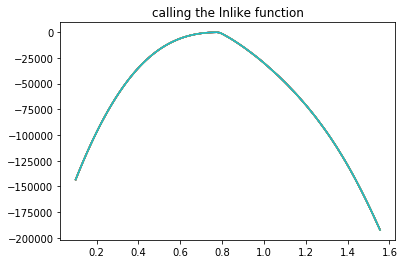

In [12]:
#plt.plot(incs, -0.5*np.array(chisq2d))
#plt.title('calling the chisq function')
#plt.show()
for vrot_fake in vrots:
    plt.plot(incs, lnlikes[f"{vrot_fake}"])
    print(incs[np.where(lnlikes[f"{vrot_fake}"] == np.max(lnlikes[f"{vrot_fake}"]))])
plt.title('calling the lnlike function')
plt.show()


In [13]:
from astropy.io import fits
import copy
from datetime import datetime
import glob
import joblib
import numpy as np
import os
import matplotlib.pyplot as plt
import corner
from tabulate import tabulate

import emcee
from emcee import EnsembleSampler, moves

In [14]:
name = "NGC2366"
distance = 3400. # [kpc]

# files needed
directory = "/Users/stephencoffey/Downloads/little-things/data"
observed_2d_vel_field_fits_file = f"{directory}/{name}_1mom.fits"
observed_2d_dispersion_fits_file = f"{directory}/{name}_2mom.fits"
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape
ring_param_file = f"{directory}/{name}_ring_parameters_rohit.txt"

# Needed for bin_edges
ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)

save_dir = "/Users/stephencoffey/Downloads/little-things/notebooks/experiments/fake_gal"
from fit2d.analysis.emcee import get_output_files, combine_results_statistics, get_sampler_statistics, plot_walker_paths, plot_posterior_distributions

In [15]:
def loadpkl(num_bins, path):
    bin_edges = np.linspace(ring_model.radii_kpc[0], ring_model.radii_kpc[-1], num_bins+1)
    d = {}
    for i in range(num_bins):
        bin_min, bin_max = bin_edges[i], bin_edges[i+1]
        with open(f'{path}/sampler_{name}_ring{i}_{bin_min:.2f}-{bin_max:.2f}.pkl', 'rb') as f:
            d[f'saved_sampler_{name}_ring{i}'] = joblib.load(f)
    return d

def grab_chain(flatten, num_bins, path):
    d = loadpkl(num_bins, path)
    
    for sampler in d.values():
        nwalkers, niter, nparams = sampler.chain.shape
        for i in range(nparams):
            if flatten == True:
                params = [np.array(sampler.flatchain[:, i])]
            else:
                params = [np.array(sampler.chain[:,:, i])]

    return params

def max_lnlike(param_names, num_bins, min_iter, max_iter, path):
    d = loadpkl(num_bins, path)
    
    ring = 0
    for sampler in d.values():
        log_probs = sampler.get_log_prob()
        print("log prob of best fit point:", np.amax(log_probs))
        log_max = np.where(log_probs == np.amax(log_probs))
        param_vals = sampler.get_chain()[log_max]
        print("inc of best fit point:", (np.degrees(param_vals[0][0])))
        
max_lnlike(['Inc'], 1, 0, 1000, f"{save_dir}/v_fixed_inc_1bin_all_fill_nan_vsys_croppedfield")

log prob of best fit point: -190464.16618524026
inc of best fit point: 60.86641806481721


In [16]:
galaxy.observed_2d_vel_field = fake_observed_2d_vel_field
dimensions = fake_observed_2d_vel_field.shape

piecewise_model = PiecewiseModel(num_bins=1)
piecewise_model.set_bounds(array_bounds=ring_param_bounds)
piecewise_model.set_bin_edges(rmin=bin_edges[0], rmax=bin_edges[-1])
radii_to_interpolate = np.array([r for r in ring_model.radii_kpc if bin_edges[0]<r<bin_edges[-1]])
prior = LinearPrior(bounds=piecewise_model.bounds)
prior_transform = prior.transform_from_unit_cube

rotation_curve_func_kwargs = {
    "radii_to_interpolate": radii_to_interpolate}
lnlike_args = {
    "model": piecewise_model,
    "rotation_curve_func_kwargs": rotation_curve_func_kwargs,
    "galaxy": galaxy,
    "ring_model": ring_model,
    "mask_sigma": mask_sigma,
    "v_err_const": v_err_const,
    "v_err_2d": v_err_2d,
    "fit_structural_params": fit_structural_params,
    "fill_nan_value": v_systemic
    }

lnlike([np.radians(45)], **lnlike_args)

IndexError: index 1 is out of bounds for axis 0 with size 1